<a href="https://colab.research.google.com/github/kairavkkp/ML-Tutorials/blob/master/DCGAN_Celeb/dcgan_celeb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Mar 17 09:43:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Using Keras Sequential API with tf.GradientTape for training
#### src : https://www.tensorflow.org/tutorials/generative/dcgan

### Steps 
- Generator (Creates images that looks real)
- Discriminator (Distinguishes b/w real and fake images)

### Process
- Keep improving the Generator till the Discriminator is not able to distinguish between them (equilibrium).
- Each step will improve both Generator and Discriminator.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q mtcnn

In [54]:
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 18.7MB/s 


#### Let's start Coding.

In [5]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [6]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

In [7]:
tf.compat.v1.enable_eager_execution()

In [11]:
import glob
import imageio
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import os
import time
import pandas as pd
import PIL
from PIL import Image
from IPython import display
from numba import cuda
from tqdm import tqdm
from mtcnn.mtcnn import MTCNN
%matplotlib inline

tf.keras.backend.clear_session()

#### Load and Prepare Dataset

In [ ]:
df_bbox = pd.read_csv('../../Datasets/celeb_data/list_bbox_celeba.csv')

In [ ]:
df_bbox.drop(101282,axis=0,inplace=True)

In [ ]:
print(f'Max Height : {max(df_bbox.height)}')
print(f'Min Height : {min(df_bbox.height)}')
print(f'Max Width : {max(df_bbox.width)}')
print(f'Min Width : {min(df_bbox.width)}')

Max Height : 5299
Min Height : 4
Max Width : 3827
Min Width : 3


In [ ]:
df_bbox[df_bbox['height'] == 0]

,image_id,x_1,y_1,width,height
101282,101283.jpg,320,828,0,0


In [ ]:
# Load an image as an rgb numpy array
def load_image(filename):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    return pixels

In [ ]:
def extract_face(model, pixels, required_size=(128, 128)):
    faces = model.detect_faces(pixels)
    # skip cases where we could not detect a face
    if len(faces) == 0:
        return None

    x1, y1, width, height = faces[0]['box']
    # force detected pixel values to be positive (bug fix)
    x1, y1 = abs(x1), abs(y1)
    # convert into coordinates
    x2, y2 = x1 + width, y1 + height
    face_pixels = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face_pixels)
    image = image.resize(required_size)
    
    return np.asarray(image)

In [ ]:
# Load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
    model = MTCNN()
    faces = list()
    
    try:
        for filename in tqdm(os.listdir(directory)[10000:], position=0, leave=True):    
            pixels = load_image(directory + filename)
            face = extract_face(model, pixels)
            if face is None:
                continue
            faces.append(face)


            # stop once we have enough
            if len(faces) >= n_faces:
                break
    except KeyboardInterrupt:
        return np.asarray(faces[:-1])
    return np.asarray(faces)

In [ ]:
# Plot a list of loaded faces
def plot_faces(faces):
    for i in range(100):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        # Plotting raw pixel data
        plt.imshow(faces[i])
    plt.show()

  0%|          | 0/202599 [00:00<?, ?it/s]

  5%|▍         | 10014/202599 [26:56<8:37:58,  6.20it/s]


Loaded:  (10000, 128, 128, 3)
<class 'numpy.ndarray'>


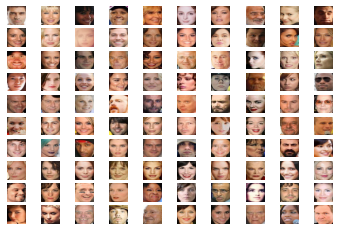

In [ ]:
directory = '../../Datasets/celeb_data/img_align_celeb/images/'
# Load and extract all faces
faces = load_faces(directory, 10000)
print('Loaded: ', faces.shape)
print(type(faces))
# Plotting faces
plot_faces(faces)

In [ ]:
with open('/content/drive/MyDrive/Celeb_GAN/img_celeba.npy', 'wb') as f:
    np.save(f, faces)

In [9]:
faces = np.load('/content/drive/MyDrive/Celeb_GAN/img_celeba.npy')

In [12]:
faces.shape

(10000, 128, 128, 3)

In [47]:
BUFFER_SIZE = faces.shape[0]
BATCH_SIZE = 64

In [48]:
train_dataset = tf.data.Dataset.from_tensor_slices(faces).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)

### Model Creation

#### Generator Model

In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*3072,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((8,8,3072)))
    assert model.output_shape == (None,8,8,3072)
    
    model.add(layers.Conv2DTranspose(1536,(5,5),strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape == (None, 8,8,1536)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(512,(5,5),strides = (2,2), padding = 'same' , use_bias = False))
    assert model.output_shape == (None, 16, 16, 512)
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(256,(5,5),strides=(2,2),padding='same',use_bias = False,activation='tanh'))
    assert model.output_shape == (None, 32, 32, 256)
    
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(96,(5,5),strides=(2,2),padding='same',use_bias = False,activation='tanh'))
    assert model.output_shape == (None, 64, 64, 96)
    
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',use_bias = False,activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model

In [16]:
generator = make_generator_model()

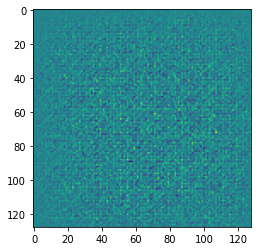

In [17]:
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0,:,:,2])

### Making the Discriminator

In [21]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same', input_shape = [128,128,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128,(5,5),strides = (2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    
    return model

In [19]:
discriminator = make_discriminator_model()

In [ ]:
decision = discriminator(generated_image)
decision

#### Defining Loss and Optimizers

In [33]:
bce = tf.keras.losses.BinaryCrossentropy()

##### Discriminator Loss

In [34]:
def discriminator_loss(real_output,fake_output):
    real_loss = bce(tf.ones_like(real_output),real_output)
    fake_loss = bce(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

##### Generator Loss

In [35]:
def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output),fake_output)

##### Optimizers

In [36]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#### Saving Checkpoints

In [38]:
checkpoint_dir = '/content/drive/MyDrive/Celeb_GAN/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                discriminator_optimizer = discriminator_optimizer,
                                generator = generator,
                                discriminator = discriminator)

#### Training

In [39]:
EPOCHS = 50
noise_dim = 100
num_ex_to_generate = 16
seed = tf.random.normal([num_ex_to_generate,noise_dim])

In [40]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True)
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [44]:
def generate_and_save_images(model,epoch, test_input):
    predictions = model(test_input,training=False)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0])
        plt.axis('off')
        
    plt.savefig(f'/content/drive/MyDrive/Celeb_GAN/images/image_at_epoch_{epoch}.png')
    plt.show()

In [45]:
def train(dataset,epochs):
    for epoch in tqdm(range(epochs),position=0, leave=True):
        start = time.time()
        
        for image_batch in tqdm(dataset,position=0, leave=True):
            train_step(image_batch)
            
        
        display.clear_output(wait=True)
        generate_and_save_images(generator,epoch+1,seed)
        
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        
        print(f'Time for epoch {epoch+1} is {time.time()-start} sec.')
    
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

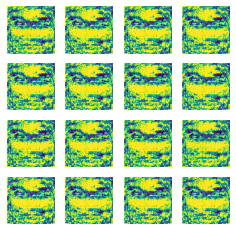

In [49]:
train(train_dataset,EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [50]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('/content/drive/MyDrive/Celeb_GAN/images/image_at_epoch_{:02d}.png'.format(epoch_no))

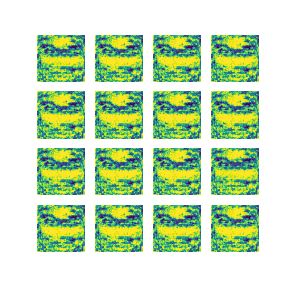

In [51]:
display_image(EPOCHS)

In [52]:
anim_file = '/content/drive/MyDrive/Celeb_GAN/dcgan-celeb.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/drive/MyDrive/Celeb_GAN/images/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


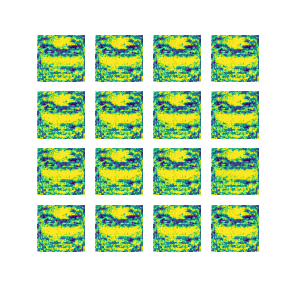

In [55]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
!cp -R /content/training_checkpoints /content/drive/MyDrive/Github/DCGAN_images_model

In [ ]:
!cp -R /content/*.png /content/drive/MyDrive/Github/DCGAN_images_model/images

In [ ]:
!cp /content/*.gif /content/drive/MyDrive/Github/DCGAN_images_model/images